<a href="https://colab.research.google.com/github/gomzi-star/siz/blob/main/SIZ_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DEFINITIONS

In [47]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sympy as sy

##rhs
Right hand sides for the 'Smooth' Izhikievich model proposed.

In [48]:
def rhs_v2(v, u , w, I, tipo):
  if tipo == 6 or tipo == 11:
    return 0.04 * v**2 + 4.1 * v + 108 - u + I + w**3
  else:
    return 0.04 * v**2 + 5 * v + 140 - u + I + w**3

def rhs_u2(v, u, w, a, b, d, A_s, w_m, tipo):
  if tipo == 17:
    return a * (b * (v + 65)) - d / A_s * (w - w_m)
  else:
    return a * (b * v - u) - d / A_s * (w - w_m)

def rhs_w2(v, w, eps):
  return (1 + 2 * eps) * w**3 - v * w**2 - (1 - 2 * eps) * w + v

def rhs2(t, z, I, a, b, d, A_s, w_m, eps, v0, l, w0, h, delta, tipo):
  v, u, w = z
  return [
          rhs_v2(v,u,w,I,tipo),
          rhs_u2(v,u,w,a,b,d,A_s,w_m,tipo),
          -rhs_w2((v - v0)/l,(w - w0)/h, eps)/delta
          ]

##imput current
Defining the way to inject current in a simulation (constant steps or ramps)

In [49]:
def input_current_array(injections, tau):
    """
    Determine the input current over time based on a list of injections, including an option
    for linear crescent currents.

    :param injections: A list of tuples where each tuple can be one of the following:
                       - (end_time, current_value): for constant current.
                       - (end_time, initial_value, slope): for linearly increasing current.
                         The first injection starts at injections[0][0].
    :param tau: The step size for time increments.
    :return: An array of current values over time.
    """
    initial_time = 0
    final_time = injections[-1][0]
    time_points = np.arange(initial_time, final_time + tau, tau)
    currents = np.zeros_like(time_points)

    base = initial_time
    for i, t in enumerate(time_points):
        for injection in injections:
            if len(injection) == 2:  # Constant current
                end_time, current_value = injection
                if t < end_time:
                    currents[i] = current_value
                    break
            elif len(injection) == 3:  # Linearly increasing current
                end_time, initial_value, slope = injection
                if t < end_time:
                    currents[i] = slope * (t - base)
                    break
                base = injection[0]
    currents[-1] = injections[-1][1]

    return currents, time_points

##siz

In [50]:
def siz(tipo, a, b, c, d, v_init, injections, v_reset,
         eps, delta, h_base, c_base, k,
         method = 'dopri5', tau = 0.1):

  #Puntos criticos
  w_c1 = np.sqrt(((4*eps + 1) + 2*np.sqrt(eps*(5*eps + 2)))/(2*eps + 1))
  w_c2 = np.sqrt(((4*eps + 1) - 2*np.sqrt(eps*(5*eps + 2)))/(2*eps + 1))
  w_c3 = -w_c2
  w_c4 = -w_c1

  v_c1 = (1 + 2 * eps * ((w_c1**2 + 1)/(w_c1**2 - 1))) * w_c1
  v_c2 = (1 + 2 * eps * ((w_c2**2 + 1)/(w_c2**2 - 1))) * w_c2
  v_c3 = -v_c2
  v_c4 = -v_c1

  #Parametros
  c      = (v_reset * (v_c4 + 1) - 2 * (c - c_base)) / (v_c4 - 1)
  v0     = (v_reset + c) / 2
  l      = (v_reset - c) / 2

  h   = ((0.04 * v0**2 + 5 * v0 + 140 - b * v_init + 0)**(1/3))  / (w_c2 * (1 - h_base))
  w0  = -w_c2 * h

  w_m = h*((1 - eps) - w_c2)
  w_min = w0 - h

  x = sy.Symbol("x")
  deltime = sy.integrate(1/(0.04*x**2 + 5*x + 140 + w_min**3), (x, v_reset, c))
  deltime = float(deltime)
  deltime = deltime * k

  A_s = 2 * h * deltime

  #Set solver rhs and method
  solver = ode(rhs2)
  solver.set_integrator(method)

  #Define time and current
  ti = 0
  tf = injections[-1][0]
  I, t = input_current_array(injections, tau)

  #Solution array
  z    = np.empty((len(t),3))
  if tipo == 17:
    z[0] = [v_init, -16, w0 + h]
  else:
    z[0] = [v_init, b*(v_init), w0 + h]

  #Solve!!!!!
  solver.set_initial_value(z[0], t[0])
  for k in range(1,len(t)):
    solver.set_f_params(I[k], a, b, d, A_s, w_m, eps, v0, l, w0, h, delta, tipo)
    solver.integrate(t[k])
    z[k]  = solver.y


  return t,z,I,c,v0,l,h,w0,w_m,w_min,deltime,A_s

##plot

In [51]:
def singleplot2(t, z, I, title, c, v_init, ubot, utop):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1,
                                      gridspec_kw={'height_ratios': [3, 0.5, 2]},
                                      figsize=(8, 6))

  # Upper plot: Membrane potential V(t)
  ax1.plot(t, z[:,0], label='v')
  ax1.plot(t, c*np.ones(len(t)), label='Threshold', linestyle='--', color='gray')
  ax1.set_ylim(bottom = v_init - 15,
               top = 30)
  ax1.set_ylabel('Membrane Potential (mV)')
  ax1.set_title(title)
  ax1.legend(loc='upper right')
  ax1.grid(True)

  # Lower plot: Current injections I(t)
  ax2.plot(t, I, color='black')
  ax2.set_ylabel('Current')
  ax2.spines['top'].set_visible(False)
  ax2.spines['right'].set_visible(False)
  ax2.spines['bottom'].set_visible(False)
  ax2.xaxis.set_ticks([])

  # Lower plot: u(t) plot
  ax3.plot(t, z[:,1], label='u', color='C1')
  ax3.set_ylabel('Recovery')
  ax3.set_xlabel('Time (ms)')
  ax3.legend(loc='upper right')
  ax3.set_ylim(bottom = ubot, top = utop)
  ax3.grid(True)

  plt.tight_layout()
  plt.show()

## default pipeline

In [52]:
def default_pipeline(tipo, v_reset = 30, eps = 1e-3, delta = 1e-4, method = 'dopri5', tau = 0.1, ubot = None, utop = None):
  title, a, b, c, d, v_init, h_base, c_base, k, injections = pars2[tipo]
  t,z,I,c,v0,l,h,w0,w_m,w_min,deltime,A_s = siz(tipo, a, b, c, d, v_init, injections, v_reset,
                                                  eps, delta, h_base, c_base, k,
                                                  method, tau);
  return t,z,I

In [53]:
def default_pipeline_plot(tipo, v_reset = 30, eps = 1e-3, delta = 1e-4, method = 'dopri5', tau = 0.1, ubot = None, utop = None):
  title, a, b, c, d, v_init, h_base, c_base, k, injections = pars2[tipo]
  t,z,I,c,v0,l,h,w0,w_m,w_min,deltime,A_s = siz(tipo, a, b, c, d, v_init, injections, v_reset,
                                                  eps, delta, h_base, c_base, k,
                                                  method, tau);
  singleplot2(t, z, I, title, c, v_init, ubot, utop)
  return t,z,I

##pars

In [54]:
pars2=[
#-names------------------------------------a-------b------c-------d----v_init---h_base--c_base-------k---injectionsssssssssss
['0 - tonic spiking',                   0.02,    0.2,   -65,      6,     -70,       0,      3,    1.04,  [[10,0],[100,14]]],
['1 - phasic spiking',                  0.02,   0.25,   -65,      6,     -64,    -0.2,      4,    1.01,  [[20,0],[200,0.5]]],
['2 - tonic bursting',                  0.02,    0.2,   -50,      2,     -70,    -0.3,      4,     1.1,  [[22,0],[220,15]]],
['3 - phasic bursting',                 0.02,   0.25,   -55,   0.05,     -64,   -0.05,    2.5,     1.1,  [[20,0],[200,0.6]]],
['4 - mixed mode',                      0.02,    0.2,   -55,      4,     -70,    -0.1,    2.5,    1.05,  [[16,0],[160,10]]],
['5 - spike frequency adaptation',      0.01,    0.2,   -65,      8,     -70,    0.18,      0,     1.1,  [[85/10,0],[85,30]]],
['6 - class 1',                         0.02,   -0.1,   -55,      6,     -60,       0,      2,   0.975,  [[30,0,0],[300,0,0.075]]], # (I RARO y NO USA EL DEL PAPER)],
['7 - class 2',                          0.2,   0.26,   -65,      0,     -64,   -0.18,      5,       1,  [[30,-0.5,0],[300,-0.5,0.015]]], # (I RARO y NO USA EL DEL PAPER)],
['8 - spike latency',                   0.02,    0.2,   -65,      6,     -70,   -0.21,      6,    1.05,  [[10,0],[13,7.04],[100,0]]],
['9 - subthreshold oscillations',       0.05,   0.26,   -60,      0,     -62,   -0.15,      4,       1,  [[20,0],[25,2],[200,0]]],
#-names------------------------------------a-------b------c-------d----v_init---h_base--c_base-------k---injectionsssssssssss
['10 - resonator',                       0.1,   0.26,   -60,     -1,     -62,    -0.3,      4,    0.65,  [[40,0],[44,0.65],[60,0],[64,0.65],[280,0],[284,0.65],[320,0],[324,0.65],[400,0]]],
['11 - integrator',                     0.02,   -0.1,   -55,      6,     -60,   -0.24,      5,    0.65,  [[100/11,0],[100/11+2,9], [100/11+5,0],[100/11+7,9], [70,0],[72,9], [80,0],[82,9],[100,0]]],
['12 - rebound spike',                  0.03,   0.25,   -60,      4,     -64,    -0.3,      4,    1.15,  [[20,0],[25,-15],[200,0]]],
['13 - rebound burst',                  0.03,   0.25,   -52,      0,     -64,    -0.3,      4,     1.2,  [[20,0],[25,-15],[200,0]]],
['14 - threshold variability',          0.03,   0.25,   -60,      4,     -64,    -0.3,      5,     1.2,  [[10,0],[15,1],[70,0],[75,-6],[80,0],[85,1],[100,0]]],
['15 - bistability',                     0.1,   0.26,   -60,      0,     -61,   -0.28,    4.5,       1,  [[37.5,0.24],[42.5,1.24],[209,0.24],[214,1.24],[300,0.24]]],
['16 - DAP',                               1,    0.2,   -60,    -21,     -70,    -0.2,    4.5,    0.94,  [[9,0],[11,20],[50,0]]],
['17 - accomodation',                   0.02,      1,   -55,      4,     -65,    -0.3,      3,       1,  [[200,0,1/25],[300,0,0],[312.5,0,1/12.5*4],[400,0,0]]], #IRARO
['18 - inhibition-induced spiking',    -0.02,     -1,   -60,      8,   -63.8,    0.35,      0,       1,  [[50,80],[225,75],[350,80]]],
['19 - inhibition-induced bursting',  -0.026,     -1,   -45,     -2,   -63.8,    0.35,   -4.5,       4,  [[50,80],[250,75],[350,80]]],
['20 - chaos',                           0.2,      2,   -56,    -16,     -60,    -0.2,      0,     0.9,  [[200,-99]]],
       ]

#RUN

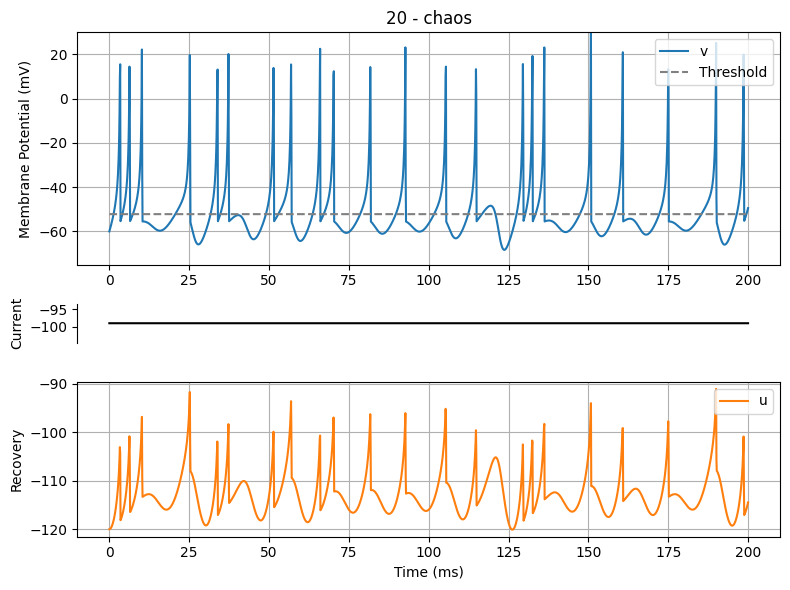

In [55]:
tipo = "20 - chaos" # @param ['0 - tonic spiking','1 - phasic spiking', '2 - tonic bursting', '3 - phasic bursting','4 - mixed mode','5 - spike frequency adaptation','6 - class 1','7 - class 2','8 - spike latency','9 - subthreshold oscillations','10 - resonator','11 - integrator','12 - rebound spike','13 - rebound burst','14 - threshold variability','15 - bistability','16 - DAP','17 - accomodation','18 - inhibition-induced spiking', '19 - inhibition-induced bursting','20 - chaos']
tipo = int(tipo.split()[0])
default_pipeline_plot(tipo = tipo);

#SHEET

In [56]:
vbox = [(-76.25086259892, 35.05956488566286),
 (-79.57158073608012, 35.21769432076572),
 (-77.95813568276048, 35.14086360394098),
 (-74.34067215412776, 34.96860343591084),
 (-76.34751314160681, 35.06416729245747),
 (-77.90167138817735, 35.138174828008445),
 (-65.44128511208686, 34.54482310057556),
 (-73.85376930471247, 34.94541758593869),
 (-82.17712461780509, 35.3417678389431),
 (-70.47843326235895, 34.78468729820757),
 (-70.87093322542167, 34.803377772639124),
 (-70.40237172141462, 34.78106532006736),
 (-87.31116387025311, 35.586245898583485),
 (-87.31116387025311, 35.586245898583485),
 (-79.8081190638241, 35.22895805065829),
 (-72.20107494760218, 34.866717854647725),
 (-75.06229377587154, 35.002966370279594),
 (-81.33494456787349, 35.301664027041596),
 (-81.92051246275125, 35.329548212511966),
 (-88.45024447735605, 35.64048783225505)]

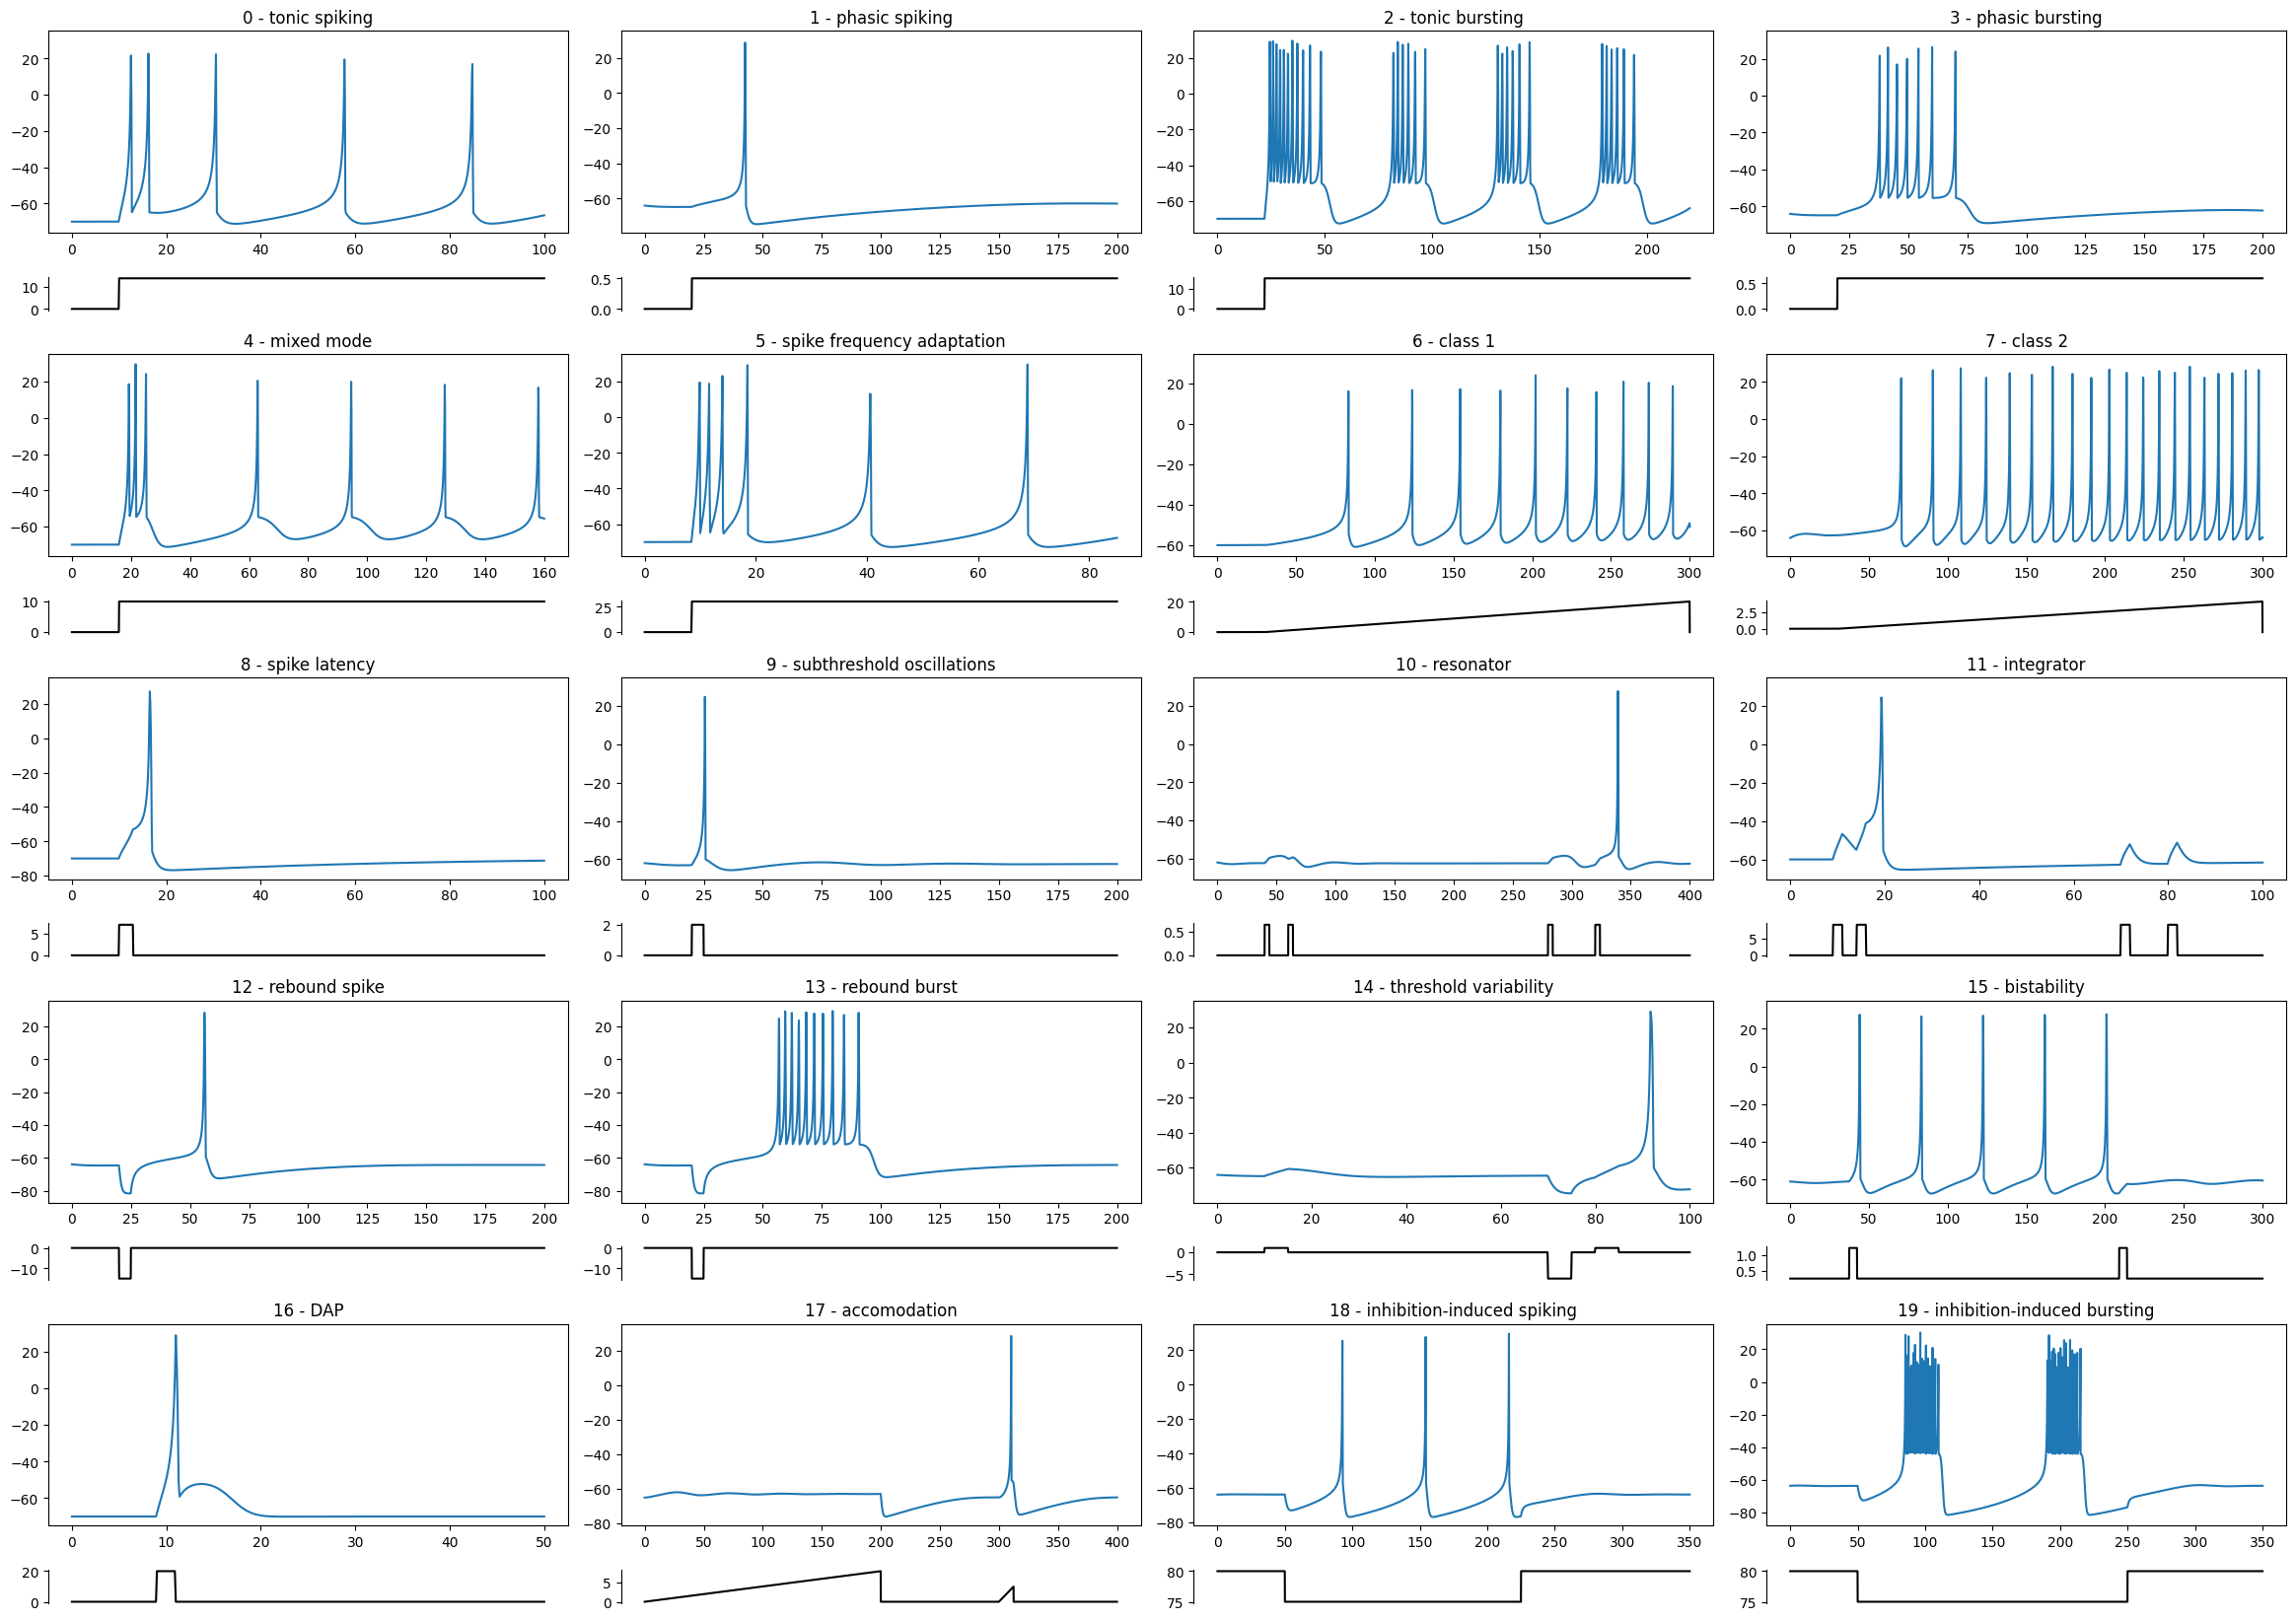

In [57]:
fig, ax = plt.subplots(ncols = 4, nrows = 10,
                       gridspec_kw={'height_ratios': [3, 0.5, 3, 0.5, 3, 0.5, 3, 0.5, 3, 0.5]},
                       figsize=(11.69*2,8.27*2),dpi=100
                      #  figsize=(8.27, 11.69), dpi=100
                       )
k = 0
for i in range(0, 10, 2):
    for j in range(4):
      t, z, I = default_pipeline(tipo = k);
      ax[i, j].plot(t, z[:,0], color = 'C0')
      ax[i, j].set_title(pars2[k][0])
      ax[i, j].set_ylim(vbox[k])

      ax[i + 1, j].plot(t, I, color = 'black')
      ax[i + 1, j].spines['top'].set_visible(False)
      ax[i + 1, j].spines['right'].set_visible(False)
      ax[i + 1, j].spines['bottom'].set_visible(False)
      ax[i + 1, j].xaxis.set_ticks([])

      k = k + 1

plt.tight_layout()
plt.show()